# Create a New MDIO File From Scratch

Here we will create an empty MDIO file and populate its fields.

```{warning}
For plotting, the notebook requires [Matplotlib](https://matplotlib.org/) as a dependency. Please install it before executing using
`pip install matplotlib` or `conda install matplotlib`.
```

We first need to import the configuration classes and create function to be able to create the empty MDIO.

In [2]:
import matplotlib.pyplot as plt

from mdio import MDIOVariableConfig, MDIOCreateConfig, Grid, Dimension, create_empty
from mdio import MDIOWriter, MDIOReader
from mdio.converters.segy import get_compressor
from mdio.segy.compat import mdio_segy_spec

## Setting Up Grid Dimensions and Variable(s)

Let's try to create an MDIO file in 3D with known `inline`, `crossline`, and `sample`
dimensions. This is exactly like a 3D Post-Stack dataset.

We will use the standard `chunked_012` access pattern. All variable names must start
with `chunked_*` for `MDIOReader` to be able to open them with any access pattern.

We will also use an MDIO private utility function to get the compressor easily. The
compressor is fully customizable, but this function gives us ones available in SEG-Y
ingestion.

If we want headers, we can also provide `header_dtype` which is a Numpy `dtype`. Again,
we will be using the standard one MDIO uses for ingesting SEG-Ys. (Similar to SEG-Y Rev1).

At the end we create empty MDIO on local disk or cloud, based on the path string.

In [3]:
grid = Grid(
    dims=[
        Dimension(name="inline", coords=range(100, 300, 1)),  # 100-300 with step 1
        Dimension(name="crossline", coords=range(1000, 1600, 2)),  # 1000-1600 with step 2
        Dimension(name="sample", coords=range(0, 3000, 4)),  # 0-3 seconds 4ms sample rate
    ]
)

compressor = get_compressor(lossless=True)
header_dtype = mdio_segy_spec().trace.header.dtype
variable = MDIOVariableConfig(
    name="chunked_012",
    dtype="float32",
    chunks=(128, 128, 128),
    compressor=compressor,
    header_dtype=header_dtype,
)

create_conf = MDIOCreateConfig(path="demo.mdio", grid=grid, variables=[variable])
create_empty(config=create_conf, overwrite=True);

# Populating the MDIO

Once empty MDIO is created, you can populate it with sample data, header data,
metadata, and statistics. The `live_mask` must be populated correctly or at
read time, traces may be skipped. After every write, the live_mask must be
updated as well.

We will read the usual stats and as you can see they're all empty. Text header
and binary header are only required if we are going to export this back to SEG-Y,
and can be modified. We can edit these if necessary using the writer.

In [4]:
writer = MDIOWriter(create_conf.path)

# Truncate text header for display
writer.text_header[:5], writer.binary_header, writer.stats

(['C00                                                                             ',
  'C01                                                                             ',
  'C02                                                                             ',
  'C03                                                                             ',
  'C04                                                                             '],
 {},
 {'rms': 0, 'mean': 0, 'max': 0, 'std': 0, 'min': 0})

# Updating File and checking with `MDIOReader`.

We write traces here, the headers are still empty. If you need the headers
populated, this is where they would be written to file as well.

All the extra metadata we are writing is so that we can export back to SEG-Y
in the future. If that's not a requirement most of the metadata can be
omitted.

If you already have an MDIO prior to this, all the metadata can be copied
over from the previous version.

In [6]:
sample_dim = writer.grid.select_dim("sample")
sample_interval = sample_dim.coords[1] - sample_dim.coords[0]
num_samples = sample_dim.size
writer.binary_header = {
    "data_sample_format": 1,
    "sample_interval": sample_interval,
    "samples_per_trace": num_samples,
    "segy_revision_major": 1,
    "segy_revision_minor": 0,
}

# Write some values to the file
writer[:5] = 1
writer[5:10] = 2
writer[50:100] = 3
writer[150:175] = -1

# Write some made up stats
writer.stats = {"mean": 12, "std": 5, "rms": 3, "min": -4, "max": 4}

reader = MDIOReader(create_conf.path)
reader.binary_header, reader.stats

({'data_sample_format': 1,
  'sample_interval': 4,
  'samples_per_trace': 750,
  'segy_revision_major': 1,
  'segy_revision_minor': 0},
 {'rms': 3, 'mean': 12, 'max': 4, 'std': 5, 'min': -4})

Plot some of the data we populated:

Text(0.5, 1.0, 'Middle Crossline')

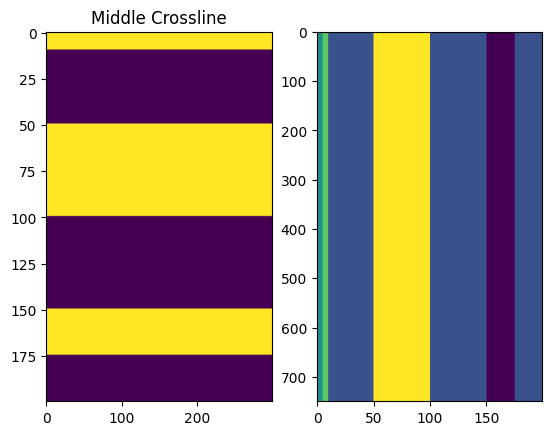

In [7]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(writer.live_mask, aspect="auto")
ax[1].imshow(reader[:, 150].T, aspect="auto")

ax[0].set_title("Live Mask")
ax[0].set_title("Middle Crossline")

# Write to SEG-Y

Because we populated all the fields necessary for SEG-Y output, we can call the
MDIO to SEGY converter and get a file out.

In [8]:
from mdio import mdio_to_segy
from segy import SegyFile


mdio_to_segy("demo.mdio", "demo.segy")
segy = SegyFile("demo.segy")
print(segy.binary_header)
print(segy.sample[:100])

Merging lines: 100%|██████████| 1/1 [00:00<00:00, 19.28it/s]

[(0, 0, 0, 0, 0, 4, 4000, 750, 750, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
